# Indexing E. Coli

If we have a reference sequence, for example E. Coli strain K12 MG1655, which is about 4.5 MB long, then using Smith-Waterman to align reads to this reference becomes quite expensive. 

We need to find a way to speed up finding areas of the reference to which our reads likely align to, making the read alignment problem tractable. 

One method of searching for substrings inside of a large text **T** is to index the position of all substrings of **T**, then break up our query sequence into identically sized substrings, look them up in the index and find likely hits. 

To test this method, execute the following code block to download the reference sequence of E. Coli to this notebook, and load the sequence into the enviromnent


In [2]:
!wget http://imolarpg.dyndns.org/stuff/ait/Reference_genome_ecoli_k12_mg1655_GCF_000005845.2_ASM584v2_genomic.fasta
  
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys
plt.style.use('seaborn-white')

--2022-03-08 19:56:02--  http://imolarpg.dyndns.org/stuff/ait/Reference_genome_ecoli_k12_mg1655_GCF_000005845.2_ASM584v2_genomic.fasta
Resolving imolarpg.dyndns.org (imolarpg.dyndns.org)... 85.238.67.23
Connecting to imolarpg.dyndns.org (imolarpg.dyndns.org)|85.238.67.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4699745 (4.5M)
Saving to: ‘Reference_genome_ecoli_k12_mg1655_GCF_000005845.2_ASM584v2_genomic.fasta’

Reference_genome_ec 100%[===================>]   4.48M  5.17MB/s    in 0.9s    

2022-03-08 19:56:03 (5.17 MB/s) - ‘Reference_genome_ecoli_k12_mg1655_GCF_000005845.2_ASM584v2_genomic.fasta’ saved [4699745/4699745]



The following function loads a reference sequence, and returns the name and the sequence from the file you just downloaded into the environment:

In [3]:
# Fasta files look like this:
#>NC_000913.3 Escherichia coli str. K-12 substr. MG1655, complete genome
#AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTG
#GTTACCTGCCGTGAGTAAATTAAAATTTTATTGACTTAGGTCACTAAATACTTTAACCAATATAGGCATAGCGCACAGAC
#AGATAAAAATTACAGAGTACACAACATCCATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGT
#AACGGTGCGGGCTGACGCGTACAGGAAACACAGAAAAAAGCCCGCACCTGACAGTGCGGGCTTTTTTTTTCGACCAAAGG
#TAACGAGGTAACAACCATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAACGTTTTCTGCGTGTTGCCG
#...
def loadFasta(filename):
  lines = list(map(str.strip,open(filename).readlines()))
  name = lines[0]
  sequence = ''.join(lines[1:])
  print(f'Loaded reference for: {name} length = {len(sequence)} from file {filename}')
  return sequence, name

sequence,name = loadFasta('Reference_genome_ecoli_k12_mg1655_GCF_000005845.2_ASM584v2_genomic.fasta')



Loaded reference for: >NC_000913.3 Escherichia coli str. K-12 substr. MG1655, complete genome length = 4641652 from file Reference_genome_ecoli_k12_mg1655_GCF_000005845.2_ASM584v2_genomic.fasta


Your task is to break up the reference sequence into kmers (substrings of length k) at different sizes, and create a hashmap (python dictionary) of them, where the keys are the kmers, and the value are a list of indices into the reference sequence. Your function takes the sequence, the kmer size, and a stride parameter. The stride parameter means you should only index every n'th kmer.

I have included a plotKmerHistogram function to make it easy to see how many times the kmers are present in the sequence. 

For a K of 20, and a stride of 1, the number of unique kmers in the input sequence length 4641652 is 4561264
The size of the of the index is 167.772272 MB
The mean of the number of hits for each kmer is: 1.0176196773525934


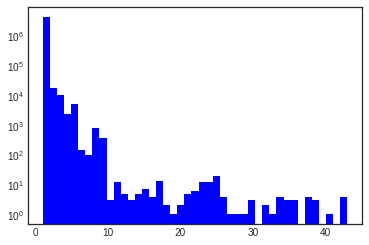

In [4]:

def plotKmerHistogram(indexdb, log = True): 
  # Creates a histogram of the number of times every kmer is observed.
  # X axis is the the number of times a specific kmer is observed
  # Y axis is the (log) count of the number of kmers observed X times
  
  #create list of counts for each kmer
  counts = list(map(len,indexdb.values()))
  plt.hist(counts, bins=max(counts), density=False,log = log,
         histtype='stepfilled', color='blue',
         edgecolor='none');
  print(f'The mean of the number of hits for each kmer is: {np.mean(counts)}')


def indexKmers(sequence,K = 25,stride = 1, log = True): # K is the size of the kmer, and we take each stride (n'th)
  indexdb = {} 
  for i in range(0, len(sequence) - K, stride):
    sub = sequence[i:i+K]
    if sub in indexdb:
      indexdb[sub] += [i]
    else:
      indexdb[sub] = [i] 

  # a dictionary of {Kmer: [occurrences list]}, 
  #e.g. for the string 'CATCAT', a K of 3 and a stride of 1, the indexdb should be: {'CAT':[0,3],'ATC':[1],'TCA':[2]}
  
  #TODO: break up sequence into K sized substrings, at every stride'th position and append their index to the corresponding kmer

      
  if log:  
    print("For a K of %d, and a stride of %d, the number of unique kmers in the input sequence length %d is %d"%(
      K,stride, len(sequence), len(indexdb)))
    print('The size of the of the index is', sys.getsizeof(indexdb)/float(1000000.0),'MB')
    plotKmerHistogram(indexdb,log=True)
  return indexdb

ecoli_index = indexKmers(sequence,K = 20,stride = 1)


**What kind of effect does changing K have on the number of times we observe a Kmer in the E. Coli reference? What is the smallest K that still makes most kmers unique?**



In [5]:
#TODO your answer goes here in code form
for i in range(19, 5, -1):
  index = indexKmers(sequence, K=i, stride = 1, log = False)
  print(f'K = {i}, unique = {len(index)}, mean hits = {np.mean(list(map(len,index.values())))}')

print('\nDecreasing K will also increase the number of times that we will observe a given Kmer, however it decreases the amount of unique Kmers present in the sequence.')
print('The smallest K that still makes most kmers unique is 12.')


K = 19, unique = 4559744, mean hits = 1.0179591222665132
K = 18, unique = 4557625, mean hits = 1.0184326266421655
K = 17, unique = 4553732, mean hits = 1.0193035075406283
K = 16, unique = 4544542, mean hits = 1.0213649692312228
K = 15, unique = 4517651, mean hits = 1.0274447937656097
K = 14, unique = 4432223, mean hits = 1.0472482995553247
K = 13, unique = 4170361, mean hits = 1.1130065238956532
K = 12, unique = 3478959, mean hits = 1.33420370863813
K = 11, unique = 2196861, mean hits = 2.112851473079089
K = 10, unique = 898115, mean hits = 5.168204517238884
K = 9, unique = 256527, mean hits = 18.09416942466095
K = 8, unique = 65360, mean hits = 71.01658506731947
K = 7, unique = 16383, mean hits = 283.32082036257094
K = 6, unique = 4096, mean hits = 1133.21435546875

Decreasing K will also increase the number of times that we will observe a given Kmer, however it decreases the amount of unique Kmers present in the sequence.
The smallest K that still makes most kmers unique is 12.


**What kind of effect does changing the stride parameter have on the size of the index?**

*Increasing the size of stride would decrease the size of the index, since we see less of the unique kmers*

# Querying the index

**Implement a function that given an index and a query string, returns the sorted position of each kmer hit!**

In [6]:
#Where inside of the genome of E. Coli could the perfectRead come from?
perfectRead = 'GTATCCCGGATTCAAAGGTCGCAAATTATAACACAGCCGCGCAGTTTGAGGTAAACCTATACGCTTTATTCACATCCAATGCCTGATATACTCGTTTGTCTTGCCAATTACGGAGTAGAAGTGCCAATGAATGCCGAAAAATCGCCGGTAAACCATAACG'
import time

def queryIndex(indexdb,query,stride = 1):
  querytime = time.time()
  K = len(next(iter(indexdb))) #Identify the Kmer size in the index database
  hits = []
  
  #TODO: take every stride'th K sized substring of the query, and collect all of the hits in a list.
  #return a list of sorted hits
  for i in range(0, len(query) - K, stride):
    sub = query[i:i+K]
    if sub in indexdb:
      hits += indexdb[sub]


 
  print('Query of length %d with an indexSize of %d has %d hits in %.3f milliseconds'%(
      len(query),K,len(hits),time.time()-querytime))
  return sorted(hits)


hitsForPerfectRead = queryIndex(ecoli_index,perfectRead)
print(hitsForPerfectRead)

# Does the reference and the largest consecutive hit match?
print('The reference and the largest consecutive hit match, since the query has 140 hits with index size of 20, meaning that there is a hit with 160 characters, which is the length of the query.')





Query of length 160 with an indexSize of 20 has 140 hits in 0.000 milliseconds
[2339440, 2339441, 2339442, 2339443, 2339444, 2339445, 2339446, 2339447, 2339448, 2339449, 2339450, 2339451, 2339452, 2339453, 2339454, 2339455, 2339456, 2339457, 2339458, 2339459, 2339460, 2339461, 2339462, 2339463, 2339464, 2339465, 2339466, 2339467, 2339468, 2339469, 2339470, 2339471, 2339472, 2339473, 2339474, 2339475, 2339476, 2339477, 2339478, 2339479, 2339480, 2339481, 2339482, 2339483, 2339484, 2339485, 2339486, 2339487, 2339488, 2339489, 2339490, 2339491, 2339492, 2339493, 2339494, 2339495, 2339496, 2339497, 2339498, 2339499, 2339500, 2339501, 2339502, 2339503, 2339504, 2339505, 2339506, 2339507, 2339508, 2339509, 2339510, 2339511, 2339512, 2339513, 2339514, 2339515, 2339516, 2339517, 2339518, 2339519, 2339520, 2339521, 2339522, 2339523, 2339524, 2339525, 2339526, 2339527, 2339528, 2339529, 2339530, 2339531, 2339532, 2339533, 2339534, 2339535, 2339536, 2339537, 2339538, 2339539, 2339540, 2339541, 23

# Filtering the hits to find candidate regions

Now that we have found where the kmers of our query can be found in the reference, how do we narrow down the search area to find the best place to start performing the Smith Waterman algorithm?

**Implement a function, that takes the sorted list of hits returned by your queryIndex function, and outputs an ordered list of candidate regions that read could come from. Each candidate reqion is a list of hit positions, and the starts and ends of the list are their minimum and maximum (first and last) values.**

*Hint: If this seems difficult, try iterating through the list of hits, and whenever the next hit is 'distant' from the current one, start a new candidate.* 


In [8]:

def ConsecutiveHits(hits,gapSize = 50):
  #the first hit starts its own region.
  hitsList = [[hits[0]]]

  #TODO: implement finding regions of hits.
  for i in hits[1:]:
    if i > hitsList[-1][-1] + 2:
      hitsList.append([i])
    else:
      hitsList[-1].append(i)
  
  return sorted(hitsList,key = lambda x : len(x), reverse = True)

conseqhits =  ConsecutiveHits(hitsForPerfectRead)
print (';'.join(['%d (%d-%d)'%(len(hit),min(hit),max(hit)) for hit in conseqhits]))

print (perfectRead)
besthit = conseqhits[0]
print (sequence[min(besthit):max(besthit)])


140 (2339440-2339579)
GTATCCCGGATTCAAAGGTCGCAAATTATAACACAGCCGCGCAGTTTGAGGTAAACCTATACGCTTTATTCACATCCAATGCCTGATATACTCGTTTGTCTTGCCAATTACGGAGTAGAAGTGCCAATGAATGCCGAAAAATCGCCGGTAAACCATAACG
GTATCCCGGATTCAAAGGTCGCAAATTATAACACAGCCGCGCAGTTTGAGGTAAACCTATACGCTTTATTCACATCCAATGCCTGATATACTCGTTTGTCTTGCCAATTACGGAGTAGAAGTGCCAATGAATGCCGAAA


Lets do the same for a repeated region of E. Coli:

In [10]:
ecoli_repeat = 'GGCTGACCACAATACAGAACGACAGAACCCGCATCCAGACGATTTATCAGCCGGGGAGCTTCACGCCACTCATCAGAGTTGAAACCGCCACCGGTGAGCTGGCGAAAACGCAGCGCCGCAGCCTGGCGGATGCGCTTCAGCAGTCCGGCGGCGAAGACGGTGGCAGTGTGGTGTTCCCGCCGGTGCTGGTGCAGATGCTC'


yeer_hits = queryIndex(ecoli_index,ecoli_repeat)
conseq_yeer_hits = ConsecutiveHits(yeer_hits)

print(';'.join(['%d (%d-%d)'%(len(hit),min(hit),max(hit)) for hit in conseq_yeer_hits]))

besthit = conseq_yeer_hits[0]
print(ecoli_repeat)
print(sequence[min(besthit):max(besthit)])

Query of length 200 with an indexSize of 20 has 522 hits in 0.000 milliseconds
180 (3765279-3765458);46 (732690-732735);46 (734561-734606);46 (734684-734729);46 (3622422-3622467);35 (732756-732790);35 (734627-734661);31 (732828-732858);29 (3622316-3622344);28 (3622374-3622401)
GGCTGACCACAATACAGAACGACAGAACCCGCATCCAGACGATTTATCAGCCGGGGAGCTTCACGCCACTCATCAGAGTTGAAACCGCCACCGGTGAGCTGGCGAAAACGCAGCGCCGCAGCCTGGCGGATGCGCTTCAGCAGTCCGGCGGCGAAGACGGTGGCAGTGTGGTGTTCCCGCCGGTGCTGGTGCAGATGCTC
GGCTGACCACAATACAGAACGACAGAACCCGCATCCAGACGATTTATCAGCCGGGGAGCTTCACGCCACTCATCAGAGTTGAAACCGCCACCGGTGAGCTGGCGAAAACGCAGCGCCGCAGCCTGGCGGATGCGCTTCAGCAGTCCGGCGGCGAAGACGGTGGCAGTGTGGTGTTCCCG


**How many significant hits did you find for this repeated segment?**


In [11]:
print('I found 10 significant hits')

I found 10 significant hits


**How much time did you spend on this homework?** There are no wrong answers, I'm just looking for feedback.

Please remember to post a shareable link of your work to the Moodle :)





In [12]:
print('I spent about 1 hour on this homework')

I spent about 1 hour on this homework
